## Exercício básico de Deep Learning
___
### Classificando carinhas tristes e felizes

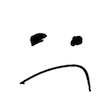 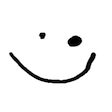

In [1]:
# Alterar o tipo de ambiente de execução para GPU
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torchvision import models
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL.Image as Image
from skimage import io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Colocar as pastas 'feliz' e 'triste' com as imagens de treino
# dentro de uma pasta 'imagens' no seu Google Drive

# Definindo o diretório das imagens de treino 
dir_img = '/content/drive/MyDrive/imagens/'

In [4]:
# Definindo alguns hiperparâmetros e variáveis
n_classes = 2 # feliz, triste
batch = 20 # está balanceado (mesma quantidade de imagens tristes e felizes)
epochs = 10

In [5]:
class FaceDataset(Dataset):
  '''Definindo nosso dataset'''
  def __init__(self, directory, transform):
    self.directory = directory
    self.transform = transform
    dir_img_feliz = os.path.join(dir_img, 'feliz')
    dir_img_triste = os.path.join(dir_img, 'triste')
    # Listar todas imagens na pasta felizes
    list_feliz = os.listdir(dir_img_feliz)
    list_feliz = [os.path.join(dir_img_feliz, i) for i in list_feliz]
    # Listar todas imagens na pasta tristes
    list_triste = os.listdir(dir_img_triste)
    list_triste = [os.path.join(dir_img_triste, i) for i in list_triste]
    # Única lista com todos os caminhos das imagens
    self.all_imgs = list_feliz + list_triste
    self.classes = [1] * len(list_feliz) + [0] * len(list_triste)

  def __len__(self):
    return len(self.all_imgs)
  
  def __getitem__(self, idx):
    path = self.all_imgs[idx]
    img = Image.open(path).convert('RGB')
    return self.transform(img), self.classes[idx]

In [6]:
# Definindo uma gpu
gpu = torch.device('cuda:0')

In [7]:
mean=(.5,.5,.5)
std=(.5,.5,.5)
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
# Criando objeto que representa nosso dataset
dataset = FaceDataset(dir_img, transformations)
# Criando objeto dataloader que carregará as imagens do nosso dataset
dataloader = DataLoader(dataset, batch_size=batch, shuffle=True)

In [8]:
# Criando nossa rede VGG
vgg = models.vgg11(pretrained=True)
# Alterando a quantidade de saídas da nossa última camada de classificação
in_features = vgg.classifier[-1].in_features
vgg.classifier[-1] = nn.Linear(in_features,n_classes)
# Colocando VGG na GPU
vgg = vgg.cuda()

In [9]:
# Função de custo (erro)
loss = nn.CrossEntropyLoss()

# Criando otimizador
optimizer = optim.Adam(vgg.parameters(), lr=0.0002)
# optimizer = optim.SGD(vgg.parameters(), lr=0.0005, momentum=0.9)

Obs.: A escolha do otimizador faz muita diferença Gradiente Descendente, Adam... Testar as opções.

In [10]:
# Criando otimizador
optimizer = optim.Adam(vgg.parameters(),lr=0.0005)

# A escolha do otimizador faz muita diferença
# Gradiente descendente, Adam... vai testando

In [11]:
# Colocando a rede em modo de treino
vgg.train()
# vgg.eval() # Ao ativar, coloca a rede em modo de inferência
epochs = 3 # Ao ativar, define um número de épocas. O estabelecido no início foi 10.

for epoch in range(epochs):
  print(f'epoch: {epoch+1}/{epochs}')
  # Percorrendo todos os batches da nossa base
  for img, c in dataloader:
    img = img.to(gpu)
    c = c.to(gpu)

    # 1. Zerando os gradientes
    optimizer.zero_grad()
    # 2. Passando imagens pela rede
    out = vgg(img)
    # 3. Calculando o erro (loss)
    l = loss(out, c)
    print(l)
    # 4. Aplicando o backpropagation
    l.backward()
    # 5. Atualizando os pesos
    optimizer.step()

epoch: 1/3


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(0.6502, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5520, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6172, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0668, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0686, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_

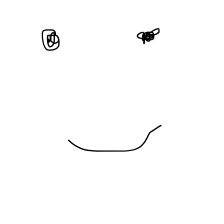

In [12]:
# Desenhar uma imagem autoral 'teste.png' com as dimensões 224 x 224
# e subir direto na pasta 'imagens' do seu Google Drive.
path = 'drive/MyDrive/imagens/teste.png'
img_teste = Image.open(path).convert('RGB')
img_teste

In [13]:
# Colocando a rede em modo de inferência
vgg.eval() 
img = transformations(img_teste)
img = img.unsqueeze(0).to(gpu)
out = vgg(img)
softmax = nn.Softmax()
out = softmax(out)
print(f'\nProbabilidade de ser triste  {out[0][0].item():.2f}')
print(f'\nProbabilidade de ser feliz   {out[0][1].item():.2f}\n')


Probabilidade de ser triste  0.00

Probabilidade de ser feliz   1.00



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
